<a href="https://colab.research.google.com/github/tvml/ml2021/blob/master/codici/mlp_mnist_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST: classifying handwritten digits

In [1]:
IS_COLAB = ('google.colab' in str(get_ipython()))
if IS_COLAB:
  %tensorflow_version 2.x

In [2]:
# Standard Python libraries
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import time
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
from pylab import subplot,imshow,title,gray,NullLocator
import imageio
from IPython import display
import sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support
from sklearn.metrics import ConfusionMatrixDisplay

from time import time

np.random.seed(0)

In [3]:

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.models import model_from_json

from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
#from tensorflow.keras.utils import np_utils
assert tf.__version__ >= "2.0"

print(tf.__version__)
#tf.config.run_functions_eagerly(False)
#import os
#os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

2.4.1


In [4]:
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['lines.linewidth'] = 2

colors = ['#008fd5', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b', '#810f7c', '#137e6d', '#be0119', '#3b638c', '#af6f09']

In [58]:
if IS_COLAB:
  from google.colab import drive
  drive.mount('/gdrive')
  filepath = "/gdrive/My Drive/colab_data/"
else:
  filepath = "./"

In [6]:
def save_model(m,filename):
    model_json = m.to_json()
    with open(filepath+filename+".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    m.save_weights(filepath+filename+".h5")
    print("Saved model to disk")

def load_model_weights(filename, model):
    model.load_weights(filepath+filename+".h5")
    print("Loaded weights from disk")
    return model

def load_model(filename):
    json_file = open(filepath+filename+'.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    m = model_from_json(loaded_model_json)
    # load weights into new model
    m.load_weights(filepath+filename+".h5")
    print("Loaded model from disk")
    return m

In [7]:
def displayData(X, t, rows=10, cols=10, img_ind=None, size =16, class_value = False):
    if len(X)>rows*cols:
        img_ind = np.random.permutation(len(X))[0:rows * cols]
    else:
        img_ind = range(rows*cols)
    fig = plt.figure(figsize = (size,size))
    #fig.patch.set_facecolor('white')
    ax = fig.gca()
    for i in range(100):
        plt.subplot(10,10,i+1)
        plt.imshow([255-x for x in X[img_ind[i]]], cmap='gray', interpolation='gaussian')
        if class_value:
            plt.title("{}".format(t[img_ind[i]]),fontsize = 16, color='C1')
        plt.gca().xaxis.set_major_locator(plt.NullLocator())
        plt.gca().yaxis.set_major_locator(plt.NullLocator())
        plt.axis('off')
    plt.subplots_adjust(top=1)
    plt.show()

In [49]:
def plotMeasure(history_train, history_test, title=''):
    plt.figure(figsize = (12,8))
    plt.plot(history_train, marker='o', markersize=5, label='Train')
    plt.plot(history_test, marker='o', markersize=5, label='Test')
    plt.legend()
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.title(title)
    plt.show()

In [9]:
def plotData(X, Y, c, npixel=28):
    image = np.array(X[c,:])
    plt.figure(figsize = (4,4))
    plt.imshow((image.reshape(npixel, npixel)), cmap='Greys', interpolation='gaussian')
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [10]:
def plot_label_dist(predictions_probs, true_label):
  plt.figure(figsize = (4,4))
  thisplot = plt.bar(range(10), predictions_probs, color="#777777")
  plt.ylim([0, 1]) 
  thisplot[predicted_class].set_color('C0')
  thisplot[true_label].set_color('C1')
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  plt.show()

Load set of images with their correct classification. Split the set in a training set, used for learning a classifier, and a test (validation) set, used for checking the quality of the classifier

In [11]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data() 
class_names = [str(x) for x in range(10)]
train_images = train_images / 255.0
test_images = test_images / 255.0
print(f'Shape of training set of images: {train_images.shape}. {train_images.shape[0]} images of size {train_images.shape[1]}x{train_images.shape[2]}')
print(f'Shape of test set of images: {test_images.shape}. {test_images.shape[0]} images of size {test_images.shape[1]}x{test_images.shape[2]}')
nb_classes = np.unique(train_labels).shape[0]
print(f'Number of classes: {nb_classes}')

Shape of training set of images: (60000, 28, 28). 60000 images of size 28x28
Shape of test set of images: (10000, 28, 28). 10000 images of size 28x28
Number of classes: 10


An image is coded as a matrix 28x28 reals in [0,1] (higher value = darker color)

In [12]:
for i in range(train_images.shape[1]):
    l = []
    for j in range(train_images.shape[2]):
        l.append('{0:5.3f}'.format(train_images[0,i,j]))
    print(l)

['0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000']
['0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000']
['0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000']
['0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000

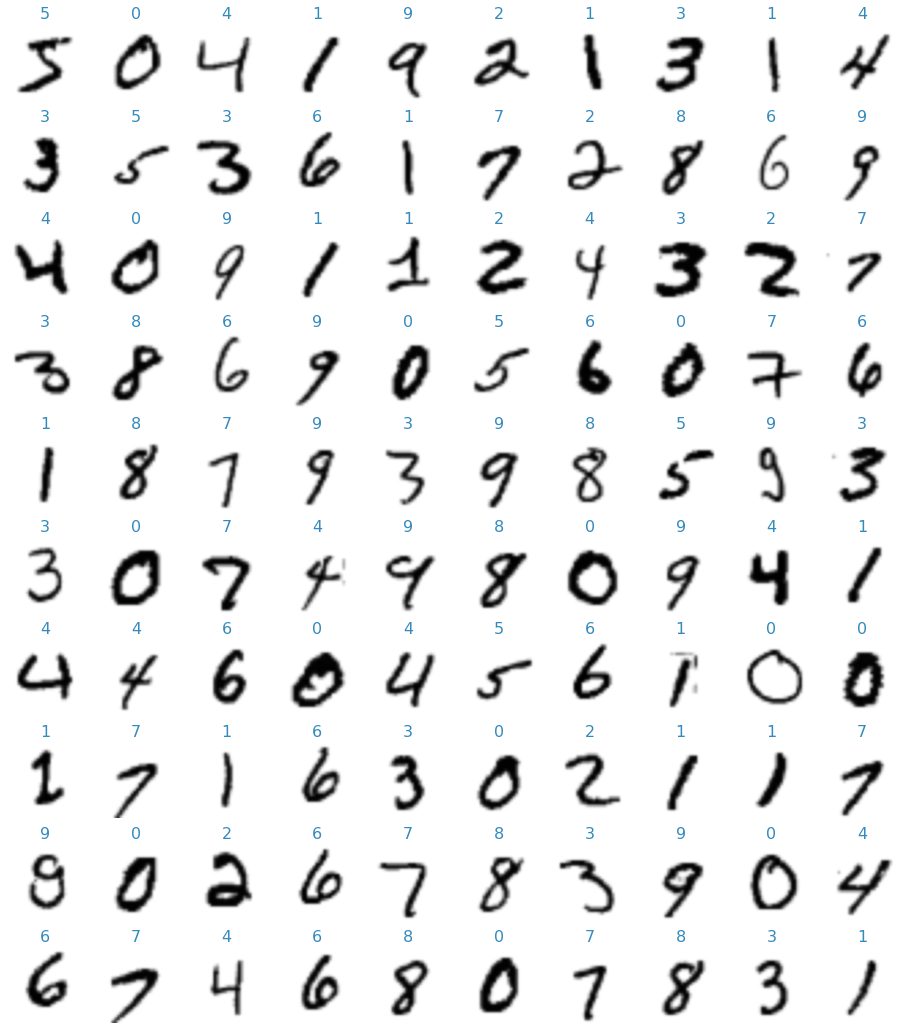

In [30]:
displayData(train_images[0:100], train_labels[0:100], class_value=True)

In [31]:
train_labels_onehot = tf.keras.utils.to_categorical(train_labels, nb_classes)
test_labels_onehot = tf.keras.utils.to_categorical(test_labels, nb_classes)

In [32]:
print(train_labels[0:5])

[5 0 4 1 9]


In [33]:
print(train_labels_onehot[0:5,:])

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


First approach: 
*   For each class, compute a linear combination of the ($28\times 28 =784$) values $x_i, i=1,\ldots, 784$ of the image, plus a constant (*bias*) $b$: that is, $785$ coefficients $w_1,\ldots, w_{784}, b$ must be defined for each class, for a total number of $785\times 10=7850$ coefficients
*   For each class, to the value resulting from the linear combination $$\sum_{i=1}^{784}w_ix_i+b$$ a suitable nonlinear function is applied (in this case the *exponential* function $e^{x}$)
*   The resulting values, one for each class, are *normalized* to sum to $1$
*   The result can be interpreted as a set of probabilities, associated to the set of disjoint events: the image belongs to the $i$-th class (it is a $0, 1, \ldots, 9$)
*   A strategy for assigning the image to a class can then be applied, such as assigning to the class of largest probability. In case, risk minimization approaches can be applied








In [55]:
model0 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

model0.summary()
model0.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [60]:
model0 = load_model_weights('softmax', model0)

Loaded weights from disk


In [56]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
time_start = time()
history0 = model0.fit(train_images, train_labels, batch_size=128, epochs=20, verbose=1, validation_data=(test_images, test_labels), callbacks=[callback])
print('time spent training {:0.3f}'.format(time() - time_start))

Epoch 1/20
  8/469 [..............................] - ETA: 6s - loss: 2.3335 - accuracy: 0.0700

/Users/giorgio/opt/anaconda3/envs/d2l/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


469/469 [==============================] - 8s 17ms/step - loss: 1.0523 - accuracy: 0.7179 - val_loss: 0.3834 - val_accuracy: 0.9016
Epoch 2/20
469/469 [==============================] - 10s 20ms/step - loss: 0.3747 - accuracy: 0.9024 - val_loss: 0.3195 - val_accuracy: 0.9133
Epoch 3/20
469/469 [==============================] - 10s 20ms/step - loss: 0.3267 - accuracy: 0.9103 - val_loss: 0.2977 - val_accuracy: 0.9168
Epoch 4/20
469/469 [==============================] - 11s 24ms/step - loss: 0.2996 - accuracy: 0.9173 - val_loss: 0.2847 - val_accuracy: 0.9200
Epoch 5/20
469/469 [==============================] - 18s 39ms/step - loss: 0.2919 - accuracy: 0.9190 - val_loss: 0.2786 - val_accuracy: 0.9234
Epoch 6/20
469/469 [==============================] - 24s 52ms/step - loss: 0.2818 - accuracy: 0.9216 - val_loss: 0.2759 - val_accuracy: 0.9237
Epoch 7/20
469/469 [==============================] - 18s 39ms/step - loss: 0.2764 - accuracy: 0.9228 - val_loss: 0.2699 - val_accuracy: 0.9235
Epoc

In [59]:
save_model(model0, 'softmax')

Saved model to disk


In [61]:
history0_df = pd.DataFrame(history0.history)
history0_df.head()

,loss,accuracy,val_loss,val_accuracy
0,0.680553,0.831033,0.383422,0.9016
1,0.361792,0.902250,0.319509,0.9133
2,0.318907,0.912417,0.297745,0.9168
3,0.299706,0.916983,0.284657,0.9200
4,0.288013,0.920433,0.278607,0.9234


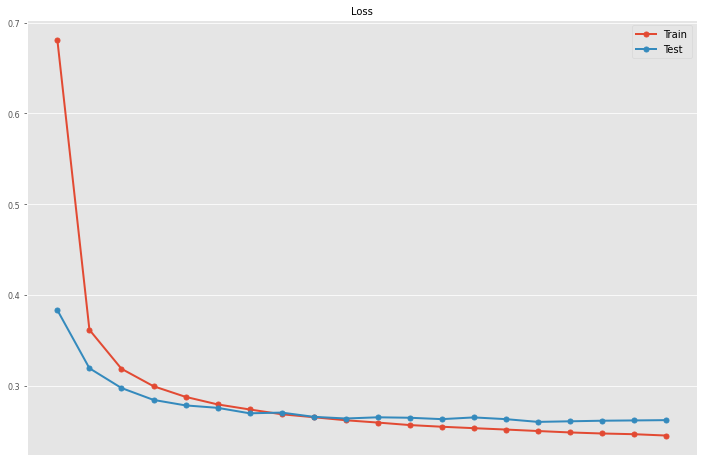

In [62]:
plotMeasure(history0_df.loss, history0_df.val_loss, 'Loss')


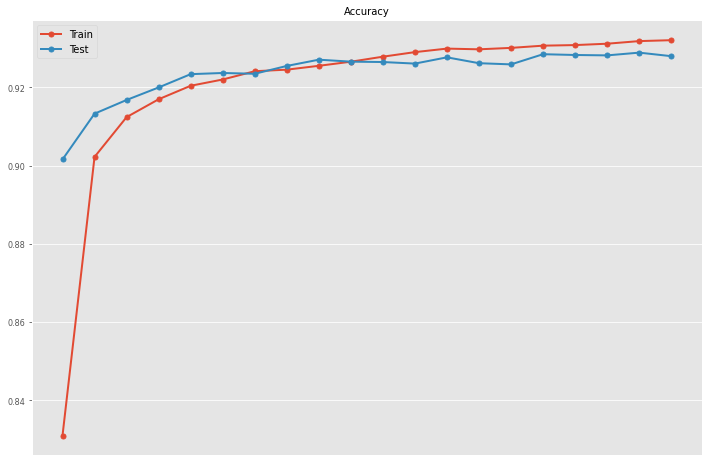

In [63]:
plotMeasure(history0_df.accuracy, history0_df.val_accuracy, 'Accuracy')

In [64]:
predictions_train = np.argmax(model0.predict(train_images), axis=-1)

/Users/giorgio/opt/anaconda3/envs/d2l/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


In [64]:
print(confusion_matrix(train_labels, predictions_train))

[[5735    1   21   13   12   47   32    6   51    5]
 [   1 6579   29   24    5   21    2    9   60   12]
 [  19   57 5424   99   64   27   47   58  146   17]
 [  12   21  118 5598    7  161   14   33  117   50]
 [   8   29   31    8 5449    7   46   15   44  205]
 [  41   21   39  163   46 4870   63   13  127   38]
 [  30   12   44    0   35   78 5678    3   37    1]
 [  10   24   61   24   43   11    3 5867   18  204]
 [  23   97   44  138   21  129   27   13 5297   62]
 [  18   26   18   82  107   33    2  127   47 5489]]


<Figure size 864x432 with 0 Axes>

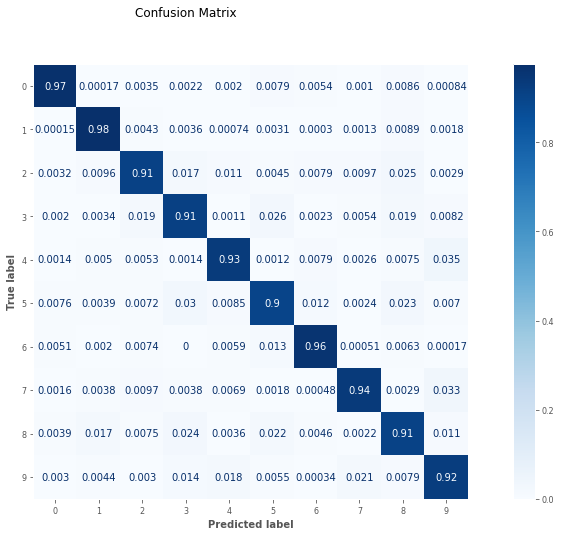

In [70]:

plt.figure(figsize=(12,6))
disp = ConfusionMatrixDisplay.from_predictions(train_labels, predictions_train, normalize='true', cmap='Blues')
disp.figure_.suptitle("Confusion Matrix")
plt.grid(None)
plt.show()

Accuracy: $$\frac{\text{\# items classified correctly}}{\text{\# items}}$$

Precision class $i$: $$\frac{\text{\# items from class $i$ classified correctly}}{\text{\# items classified as class $i$}}$$

Recall class $i$: $$\frac{\text{\# items from class $i$ classified correctly}}{\text{\# items from class $i$}}$$

F-score class $i$: $$\frac{\text{Precision classe $i$} \times \text{Recall classe $i$}}{\text{Precision classe $i$}+\text{Recall classe $i$}}$$

In [47]:
print('Training set accuracy: {0:5.3f}'.format(accuracy_score(train_labels, predictions_train)))

Training set accuracy: 0.933


In [48]:
meas = precision_recall_fscore_support(train_labels, predictions_train, average=None)
print('Training set')
for i in range(10):
  print('Class {0:d}: precision={1:5.2f}, recall={2:5.2f}, f-measure={2:5.2f}'.format(i, meas[1][i], meas[2][i], meas[3][i]))

Training set
Class 0: precision= 0.98, recall= 0.97, f-measure= 0.97
Class 1: precision= 0.98, recall= 0.97, f-measure= 0.97
Class 2: precision= 0.91, recall= 0.92, f-measure= 0.92
Class 3: precision= 0.90, recall= 0.91, f-measure= 0.91
Class 4: precision= 0.94, recall= 0.94, f-measure= 0.94
Class 5: precision= 0.90, recall= 0.90, f-measure= 0.90
Class 6: precision= 0.96, recall= 0.96, f-measure= 0.96
Class 7: precision= 0.95, recall= 0.94, f-measure= 0.94
Class 8: precision= 0.90, recall= 0.90, f-measure= 0.90
Class 9: precision= 0.91, recall= 0.91, f-measure= 0.91


In [72]:
predictions_test = np.argmax(model0.predict(test_images), axis=-1)

In [73]:
print(confusion_matrix(test_labels, predictions_test))

[[ 957    0    2    2    0    8    6    2    2    1]
 [   0 1112    3    2    0    1    4    2   11    0]
 [   4    8  926   18    7    4   10    9   43    3]
 [   2    0   17  928    1   20    2    9   25    6]
 [   1    1    5    2  912    0    8    4   11   38]
 [   7    2    2   39    8  780   11    7   31    5]
 [   9    3    9    1    7   16  908    2    3    0]
 [   1    6   22   10    6    1    0  941    5   36]
 [   5    7    5   21    9   23    7    9  880    8]
 [   9    8    1    9   21    7    0   14    9  931]]


<Figure size 864x432 with 0 Axes>

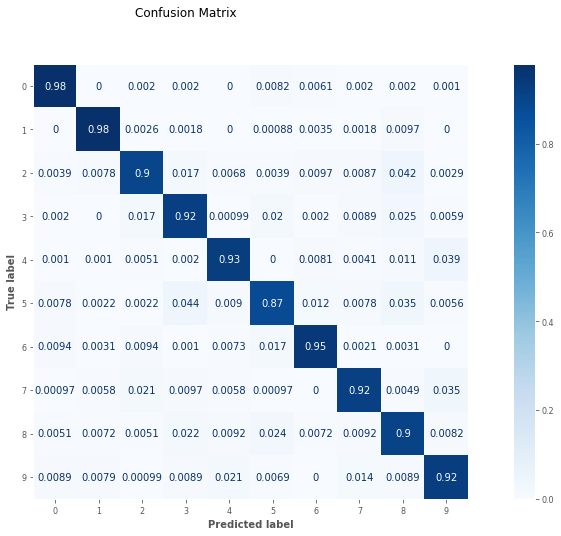

In [74]:
plt.figure(figsize=(12,6))
disp = ConfusionMatrixDisplay.from_predictions(test_labels, predictions_test, normalize='true', cmap='Blues')
disp.figure_.suptitle("Confusion Matrix")
plt.grid(None)
plt.show()

In [75]:
print('Test set accuracy: {0:5.3f}'.format(accuracy_score(test_labels, predictions_test)))

Test set accuracy: 0.927


In [76]:
meas = precision_recall_fscore_support(test_labels, predictions_test, average=None)
print('Test set')
for i in range(10):
  print('Class {0:d}: precision={1:5.2f}, recall={2:5.2f}, f-measure={2:5.2f}'.format(i, meas[1][i], meas[2][i], meas[3][i]))

Test set
Class 0: precision= 0.98, recall= 0.97, f-measure= 0.97
Class 1: precision= 0.98, recall= 0.97, f-measure= 0.97
Class 2: precision= 0.90, recall= 0.92, f-measure= 0.92
Class 3: precision= 0.92, recall= 0.91, f-measure= 0.91
Class 4: precision= 0.93, recall= 0.93, f-measure= 0.93
Class 5: precision= 0.87, recall= 0.89, f-measure= 0.89
Class 6: precision= 0.95, recall= 0.95, f-measure= 0.95
Class 7: precision= 0.92, recall= 0.93, f-measure= 0.93
Class 8: precision= 0.90, recall= 0.88, f-measure= 0.88
Class 9: precision= 0.92, recall= 0.91, f-measure= 0.91


Item 9845
Image shape: (28, 28)


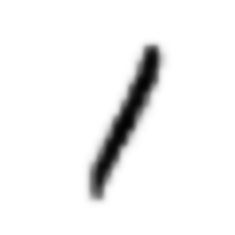

In [79]:
c = np.random.randint(0, test_images.shape[0])
img = test_images[c]
print("Item "+str(c))
print('Image shape: {}'.format(img.shape))
plotData(test_images, test_labels, c)


Shape of tensor input to model: (1, 28, 28)


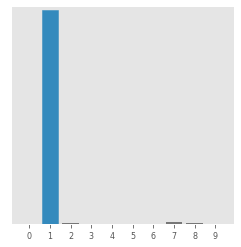

Predicted probabilities: [0.0000, 0.9851, 0.0046, 0.0013, 0.0003, 0.0000, 0.0000, 0.0060, 0.0022, 0.0005]
Class: 1. Prediction: 1


In [80]:
tensor = (np.expand_dims(img,0))
print('Shape of tensor input to model: {}'.format(tensor.shape))
predictions_probs = np.squeeze(model0.predict(tensor))
predicted_class = np.squeeze(np.argmax(predictions_probs, axis=-1))
plot_label_dist(predictions_probs, test_labels[c])
print("Predicted probabilities: ["+", ".join('%5.4f'%x for x in predictions_probs)+"]")
print("Class: "+str(test_labels[c])+". Prediction: " + str(predicted_class))

In [81]:
weights = model0.layers[1].get_weights()[0]
bias = model0.layers[1].get_weights()[1]

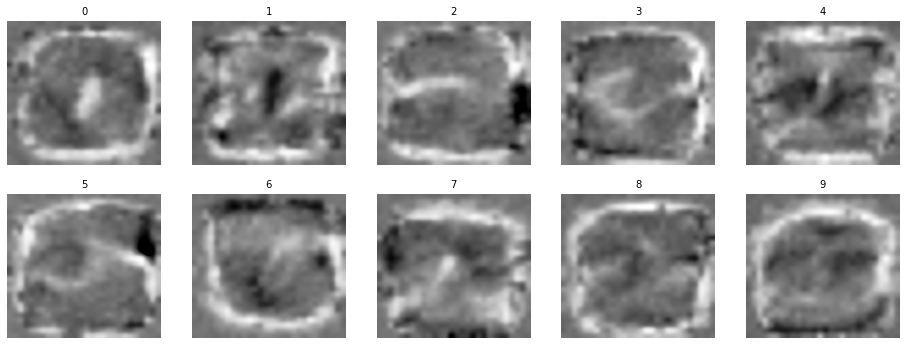

In [83]:
fig = plt.figure(figsize=(16,16))
fig.patch.set_facecolor('white')
for i in range(10):
    ax = subplot(2,5,i+1,frame_on=False, facecolor="#F8F8F8")
    ax.xaxis.set_major_locator(NullLocator())
    ax.yaxis.set_major_locator(NullLocator())
    imshow(weights[:,i].reshape(28,28), interpolation='gaussian', 
           cmap=plt.get_cmap('Greys'), vmin=np.mean(weights[:,i])-3.5*np.std(weights[:,i]), 
           vmax=np.mean(weights[:,i])+2.5*np.std(weights[:,i]), aspect='auto')
    plt.title(i)
plt.subplots_adjust(top=0.4)
plt.show()

In [66]:
model1 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(512, activation=tf.nn.relu),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])
model1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


In [67]:
model1.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [71]:
model1 = load_model_weights('nn3', model1)

Loaded weights from disk


In [69]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
time_start = time()
history1 = model1.fit(train_images, train_labels, batch_size=128, epochs=10, verbose=1, validation_data=(test_images, test_labels), callbacks=[callback])
print('time spent training {:0.3f}'.format(time() - time_start))

Epoch 1/10
469/469 [==============================] - 10s 22ms/step - loss: 0.4942 - accuracy: 0.8577 - val_loss: 0.1384 - val_accuracy: 0.9595
Epoch 2/10
469/469 [==============================] - 14s 29ms/step - loss: 0.1320 - accuracy: 0.9620 - val_loss: 0.1001 - val_accuracy: 0.9704
Epoch 3/10
469/469 [==============================] - 16s 34ms/step - loss: 0.0885 - accuracy: 0.9746 - val_loss: 0.0780 - val_accuracy: 0.9772
Epoch 4/10
469/469 [==============================] - 17s 37ms/step - loss: 0.0624 - accuracy: 0.9814 - val_loss: 0.0690 - val_accuracy: 0.9782
Epoch 5/10
469/469 [==============================] - 18s 39ms/step - loss: 0.0516 - accuracy: 0.9844 - val_loss: 0.0641 - val_accuracy: 0.9796
Epoch 6/10
469/469 [==============================] - 20s 42ms/step - loss: 0.0401 - accuracy: 0.9883 - val_loss: 0.0607 - val_accuracy: 0.9810
Epoch 7/10
469/469 [==============================] - 22s 48ms/step - loss: 0.0350 - accuracy: 0.9900 - val_loss: 0.0637 - val_accuracy:

In [70]:
save_model(model1,'nn3')

Saved model to disk


In [72]:
history1_df = pd.DataFrame(history1.history)
history1_df.head()

,loss,accuracy,val_loss,val_accuracy
0,0.288287,0.916933,0.138449,0.9595
1,0.123108,0.963933,0.100078,0.9704
2,0.085425,0.975017,0.078049,0.9772
3,0.063371,0.980967,0.068981,0.9782
4,0.051225,0.984367,0.064092,0.9796


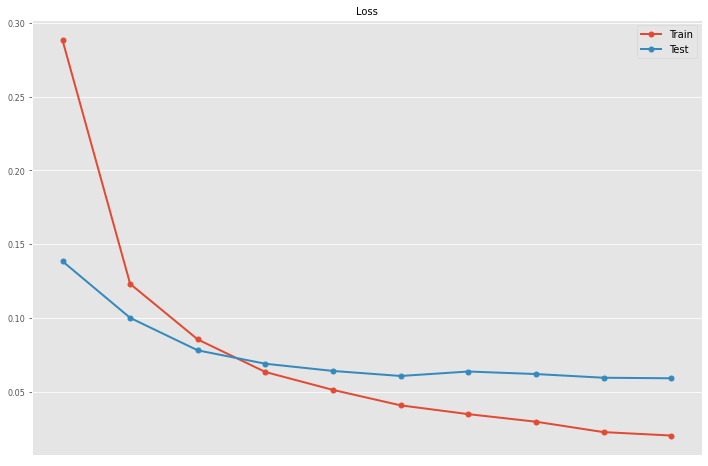

In [74]:
plotMeasure(history1_df.loss, history1_df.val_loss, 'Loss')

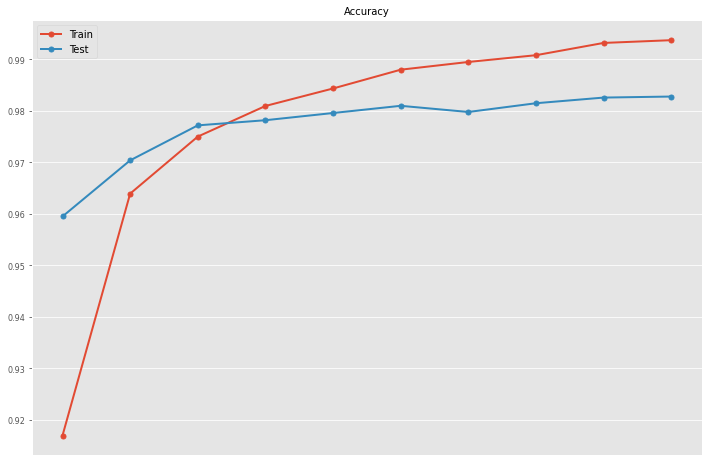

In [75]:
plotMeasure(history1_df.accuracy, history1_df.val_accuracy, 'Accuracy')

In [92]:
predictions_train_1 = np.argmax(model1.predict(train_images), axis=-1)

In [93]:
print(confusion_matrix(train_labels, predictions_train_1))

[[5917    0    0    1    0    0    3    0    2    0]
 [   0 6709   15    2    1    0    0    4   10    1]
 [   3    1 5952    1    0    0    0    0    0    1]
 [   0    0    2 6118    0    6    0    0    2    3]
 [   0    2    1    0 5827    0    0    1    0   11]
 [   2    0    0    7    0 5396    9    1    6    0]
 [   1    0    0    0    2    0 5915    0    0    0]
 [   0    4    5    0    1    0    0 6248    1    6]
 [   0    2    2    6    0    0    1    1 5839    0]
 [   2    1    0    0    3    0    0    5    3 5935]]


<Figure size 864x432 with 0 Axes>

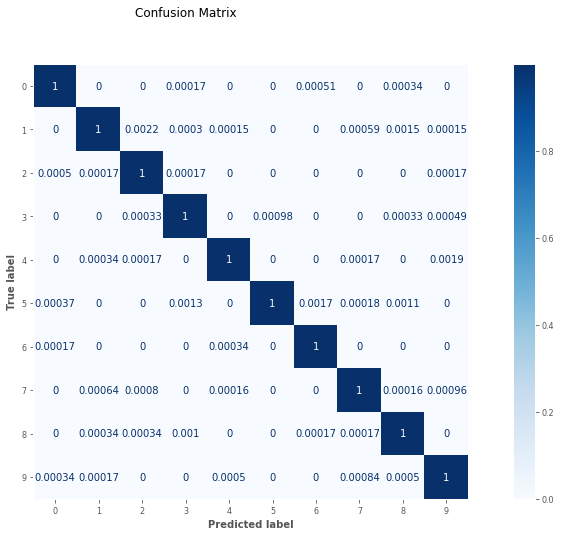

In [100]:
plt.figure(figsize=(12,6))
disp = ConfusionMatrixDisplay.from_predictions(train_labels, predictions_train_1, normalize='true', cmap='Blues')
disp.figure_.suptitle("Confusion Matrix")
plt.grid(None)
plt.show()

In [95]:
print('Training set accuracy: {0:5.3f}'.format(accuracy_score(train_labels, predictions_train_1)))

Training set accuracy: 0.998


In [96]:
meas = precision_recall_fscore_support(train_labels, predictions_train_1, average=None)
print('Training set')
for i in range(10):
  print('Class {0:d}: precision={1:5.3f}, recall={2:5.3f}, f-measure={2:5.3f}'.format(i, meas[1][i], meas[2][i], meas[3][i]))

Training set
Class 0: precision=0.999, recall=0.999, f-measure=0.999
Class 1: precision=0.995, recall=0.997, f-measure=0.997
Class 2: precision=0.999, recall=0.997, f-measure=0.997
Class 3: precision=0.998, recall=0.998, f-measure=0.998
Class 4: precision=0.997, recall=0.998, f-measure=0.998
Class 5: precision=0.995, recall=0.997, f-measure=0.997
Class 6: precision=0.999, recall=0.999, f-measure=0.999
Class 7: precision=0.997, recall=0.998, f-measure=0.998
Class 8: precision=0.998, recall=0.997, f-measure=0.997
Class 9: precision=0.998, recall=0.997, f-measure=0.997


In [97]:
predictions_test_1 = np.argmax(model1.predict(test_images), axis=-1)

In [98]:
print(confusion_matrix(test_labels, predictions_test_1))

[[ 974    0    0    1    0    0    1    1    3    0]
 [   0 1123    3    1    0    0    2    0    6    0]
 [   2    0 1015    2    2    0    2    4    4    1]
 [   0    0    3  995    0    3    0    2    3    4]
 [   2    0    2    0  960    0    3    3    1   11]
 [   2    0    0    8    1  868    7    1    3    2]
 [   4    2    0    1    3    1  946    0    1    0]
 [   0    4   11    1    0    0    0 1003    4    5]
 [   4    0    2    5    2    1    1    2  953    4]
 [   2    3    0    5    7    1    1    5    4  981]]


<Figure size 864x432 with 0 Axes>

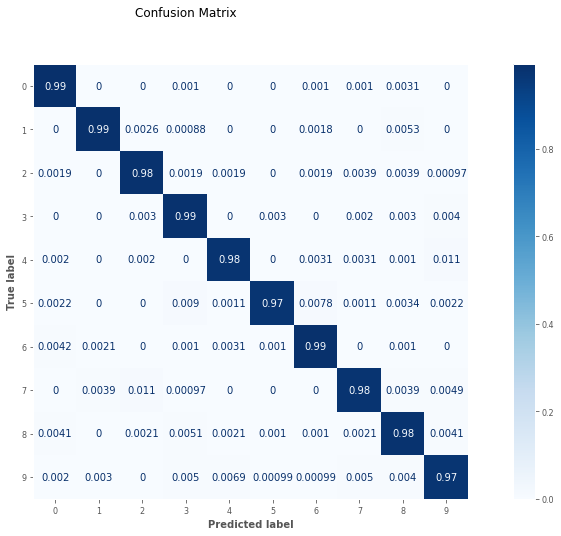

In [101]:
plt.figure(figsize=(12,6))
disp = ConfusionMatrixDisplay.from_predictions(test_labels, predictions_test_1, normalize='true', cmap='Blues')
disp.figure_.suptitle("Confusion Matrix")
plt.grid(None)
plt.show()

In [164]:
print('Test set accuracy: {0:5.3f}'.format(accuracy_score(test_labels, predictions_test_1)))

Test set accuracy: 0.984


In [165]:
meas = precision_recall_fscore_support(test_labels, predictions_test_1, average=None)
print('Test set')
for i in range(10):
  print('Class {0:d}: precision={1:5.3f}, recall={2:5.3f}, f-measure={2:5.3f}'.format(i, meas[1][i], meas[2][i], meas[3][i]))

Test set
Class 0: precision=0.986, recall=0.987, f-measure=0.987
Class 1: precision=0.992, recall=0.993, f-measure=0.993
Class 2: precision=0.982, recall=0.982, f-measure=0.982
Class 3: precision=0.987, recall=0.987, f-measure=0.987
Class 4: precision=0.977, recall=0.984, f-measure=0.984
Class 5: precision=0.983, recall=0.985, f-measure=0.985
Class 6: precision=0.987, recall=0.984, f-measure=0.984
Class 7: precision=0.984, recall=0.983, f-measure=0.983
Class 8: precision=0.979, recall=0.979, f-measure=0.979
Class 9: precision=0.983, recall=0.978, f-measure=0.978


In [13]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(512, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
__________________________________________________

In [15]:
model2.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [202]:
model2 = load_model_weights('nn4', model2)

Loaded weights from disk


In [16]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
time_start = time()
history2 = model2.fit(train_images, train_labels, batch_size=128, epochs=10, verbose=1, validation_data=(test_images, test_labels), callbacks=[callback])
print('time spent training {:0.3f}'.format(time() - time_start))

Epoch 1/10
469/469 [==============================] - 11s 21ms/step - loss: 0.4461 - accuracy: 0.8670 - val_loss: 0.1036 - val_accuracy: 0.9662
Epoch 2/10
469/469 [==============================] - 8s 17ms/step - loss: 0.1032 - accuracy: 0.9680 - val_loss: 0.0921 - val_accuracy: 0.9704
Epoch 3/10
469/469 [==============================] - 8s 17ms/step - loss: 0.0719 - accuracy: 0.9776 - val_loss: 0.0644 - val_accuracy: 0.9800
Epoch 4/10
469/469 [==============================] - 8s 18ms/step - loss: 0.0551 - accuracy: 0.9824 - val_loss: 0.0681 - val_accuracy: 0.9776
Epoch 5/10
469/469 [==============================] - 8s 17ms/step - loss: 0.0437 - accuracy: 0.9862 - val_loss: 0.0623 - val_accuracy: 0.9816
Epoch 6/10
469/469 [==============================] - 8s 17ms/step - loss: 0.0365 - accuracy: 0.9874 - val_loss: 0.0669 - val_accuracy: 0.9808
Epoch 7/10
469/469 [==============================] - 8s 17ms/step - loss: 0.0325 - accuracy: 0.9890 - val_loss: 0.0633 - val_accuracy: 0.981

In [17]:
save_model(model2,'nn4')

Saved model to disk


In [18]:
history2_df = pd.DataFrame(history2.history)
history2_df.head()

,loss,accuracy,val_loss,val_accuracy
0,0.248149,0.925350,0.103561,0.9662
1,0.100150,0.969150,0.092082,0.9704
2,0.071586,0.977267,0.064410,0.9800
3,0.055438,0.982133,0.068098,0.9776
4,0.045539,0.985467,0.062264,0.9816


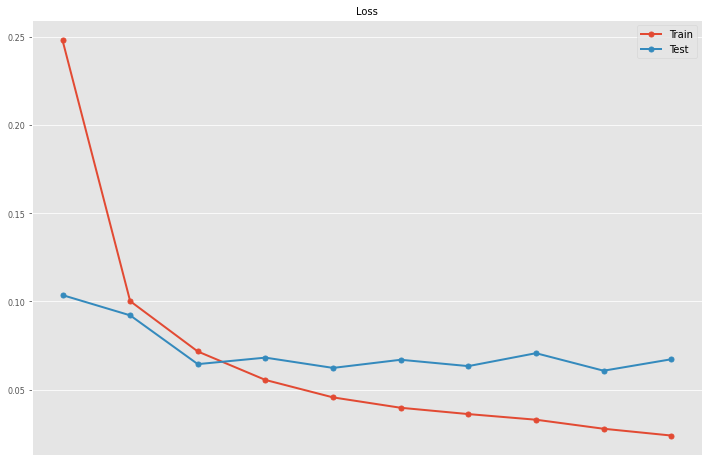

In [77]:
plotMeasure(history2_df.loss, history2_df.val_loss, 'Loss')

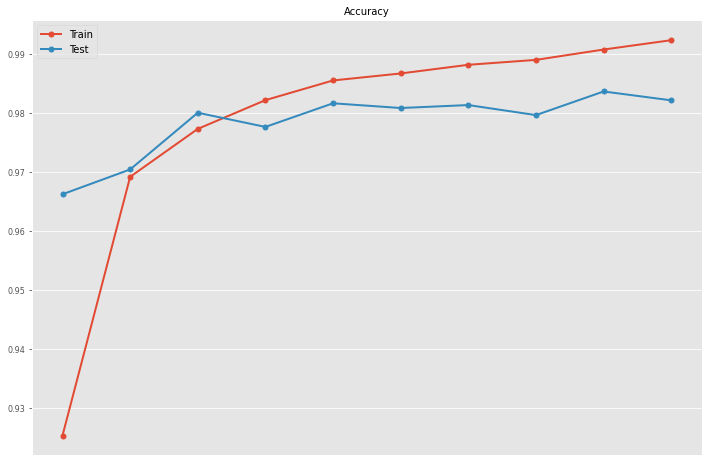

In [76]:
plotMeasure(history2_df.accuracy, history2_df.val_accuracy, 'Accuracy')

In [24]:
predictions_train_2 = np.argmax(model2.predict(train_images), axis=-1)

In [28]:
confusion_matrix(train_labels, predictions_train_2)

array([[5922,    0,    0,    0,    0,    0,    0,    0,    1,    0],
       [   0, 6730,    0,    0,    0,    1,    0,    7,    4,    0],
       [  10,    1, 5943,    0,    3,    0,    0,    0,    1,    0],
       [   1,    0,    6, 6105,    0,    2,    0,    3,    7,    7],
       [   0,    3,    0,    0, 5830,    0,    0,    2,    0,    7],
       [   0,    0,    0,    7,    0, 5397,    7,    1,    6,    3],
       [  99,    1,    0,    0,    2,    1, 5813,    0,    2,    0],
       [   0,    0,    1,    0,    0,    0,    0, 6258,    2,    4],
       [   8,    3,    2,    0,    2,    0,    0,    0, 5833,    3],
       [   2,    0,    0,    0,    4,    0,    0,    8,    3, 5932]])

<Figure size 864x432 with 0 Axes>

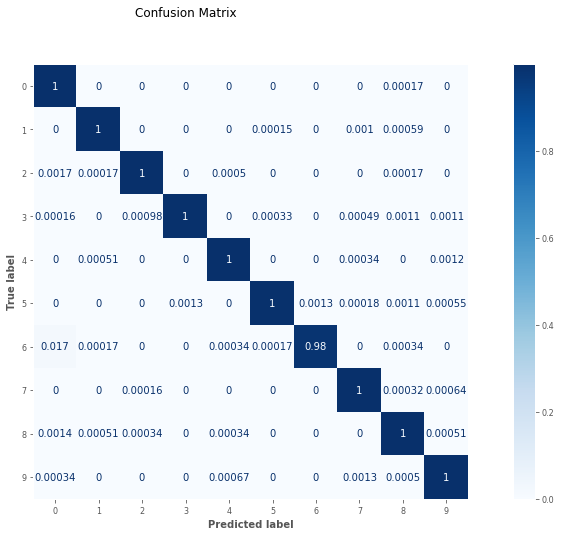

In [29]:
plt.figure(figsize=(12,6))
disp = ConfusionMatrixDisplay.from_predictions(train_labels, predictions_train_2, normalize='true', cmap='Blues')
disp.figure_.suptitle("Confusion Matrix")
plt.grid(None)
plt.show()

In [30]:
print('Training set accuracy: {0:5.3f}'.format(accuracy_score(train_labels, predictions_train_2)))

Training set accuracy: 0.996


In [31]:
meas = precision_recall_fscore_support(train_labels, predictions_train_2, average=None)
print('Training set')
for i in range(10):
  print('Class {0:d}: precision={1:5.3f}, recall={2:5.3f}, f-measure={2:5.3f}'.format(i, meas[1][i], meas[2][i], meas[3][i]))

Test set
Class 0: precision=1.000, recall=0.990, f-measure=0.990
Class 1: precision=0.998, recall=0.999, f-measure=0.999
Class 2: precision=0.997, recall=0.998, f-measure=0.998
Class 3: precision=0.996, recall=0.997, f-measure=0.997
Class 4: precision=0.998, recall=0.998, f-measure=0.998
Class 5: precision=0.996, recall=0.997, f-measure=0.997
Class 6: precision=0.982, recall=0.990, f-measure=0.990
Class 7: precision=0.999, recall=0.998, f-measure=0.998
Class 8: precision=0.997, recall=0.996, f-measure=0.996
Class 9: precision=0.997, recall=0.997, f-measure=0.997


In [32]:
predictions_test_2 = np.argmax(model2.predict(test_images), axis=-1)

/Users/giorgio/opt/anaconda3/envs/d2l/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


In [33]:
confusion_matrix(test_labels, predictions_test_2)

array([[ 977,    0,    0,    1,    1,    0,    0,    1,    0,    0],
       [   0, 1129,    2,    1,    0,    0,    0,    0,    3,    0],
       [   6,    0, 1009,    1,    8,    0,    2,    5,    1,    0],
       [   0,    0,    5,  992,    0,    2,    0,    5,    4,    2],
       [   1,    0,    2,    0,  965,    0,    2,    2,    0,   10],
       [   2,    0,    0,    7,    0,  873,    2,    1,    5,    2],
       [  19,    3,    0,    1,    7,    2,  924,    0,    2,    0],
       [   1,    0,    7,    0,    0,    0,    0, 1012,    2,    6],
       [   9,    0,    2,    1,    4,    1,    1,    4,  948,    4],
       [   3,    2,    0,    0,    5,    1,    0,    3,    3,  992]])

<Figure size 864x432 with 0 Axes>

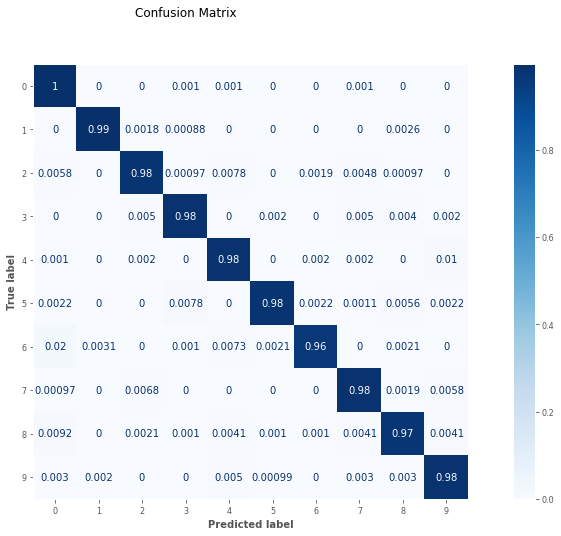

In [34]:
plt.figure(figsize=(12,6))
disp = ConfusionMatrixDisplay.from_predictions(test_labels, predictions_test_2, normalize='true', cmap='Blues')
disp.figure_.suptitle("Confusion Matrix")
plt.grid(None)
plt.show()

In [35]:
print('Test set accuracy: {0:5.3f}'.format(accuracy_score(test_labels, predictions_test_2)))

Test set accuracy: 0.982


In [36]:
meas = precision_recall_fscore_support(test_labels, predictions_test_2, average=None)
print('Test set')
for i in range(10):
  print('Class {0:d}: precision={1:5.3f}, recall={2:5.3f}, f-measure={2:5.3f}'.format(i, meas[1][i], meas[2][i], meas[3][i]))

Test set
Class 0: precision=0.997, recall=0.978, f-measure=0.978
Class 1: precision=0.995, recall=0.995, f-measure=0.995
Class 2: precision=0.978, recall=0.980, f-measure=0.980
Class 3: precision=0.982, recall=0.985, f-measure=0.985
Class 4: precision=0.983, recall=0.979, f-measure=0.979
Class 5: precision=0.979, recall=0.986, f-measure=0.986
Class 6: precision=0.965, recall=0.978, f-measure=0.978
Class 7: precision=0.984, recall=0.982, f-measure=0.982
Class 8: precision=0.973, recall=0.976, f-measure=0.976
Class 9: precision=0.983, recall=0.980, f-measure=0.980


In [20]:
model3 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(30, (5, 5), input_shape=(28, 28,1), activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(15, (3, 3), activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(50, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

model3.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 30)        780       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 30)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 10, 15)        4065      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 15)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 5, 5, 15)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 375)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)              

In [21]:
model3.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [175]:
model3 = load_model_weights('cnn', model3)

OSError: Unable to open file (unable to open file: name = '../ml_storecnn.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [22]:
train_images_tensor = train_images.reshape(train_images.shape[0], 28, 28,1).astype('float32')
test_images_tensor = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')

In [23]:

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
time_start = time()
history3 = model3.fit(train_images_tensor, train_labels, batch_size=128, epochs=5, verbose=1, validation_data=(test_images_tensor, test_labels), callbacks=[callback])
print(f'time spent training {time() - time_start:0.3f}')


/Users/giorgio/opt/anaconda3/envs/d2l/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


Epoch 1/5
469/469 [==============================] - 81s 173ms/step - loss: 0.6719 - accuracy: 0.7858 - val_loss: 0.0767 - val_accuracy: 0.9754
Epoch 2/5
469/469 [==============================] - 77s 163ms/step - loss: 0.0960 - accuracy: 0.9708 - val_loss: 0.0492 - val_accuracy: 0.9843
Epoch 3/5
469/469 [==============================] - 80s 170ms/step - loss: 0.0649 - accuracy: 0.9801 - val_loss: 0.0374 - val_accuracy: 0.9884
Epoch 4/5
469/469 [==============================] - 85s 181ms/step - loss: 0.0524 - accuracy: 0.9832 - val_loss: 0.0410 - val_accuracy: 0.9860
Epoch 5/5
469/469 [==============================] - 92s 195ms/step - loss: 0.0433 - accuracy: 0.9867 - val_loss: 0.0442 - val_accuracy: 0.9871
time spent training 414.051


In [25]:
save_model(model3,'cnn')

Saved model to disk


In [26]:
history3_df = pd.DataFrame(history3.history) 
history3_df.head()


,loss,accuracy,val_loss,val_accuracy
0,0.304500,0.905267,0.076709,0.9754
1,0.088103,0.973067,0.049176,0.9843
2,0.062979,0.980533,0.037358,0.9884
3,0.051373,0.983750,0.041014,0.9860
4,0.044116,0.985767,0.044174,0.9871


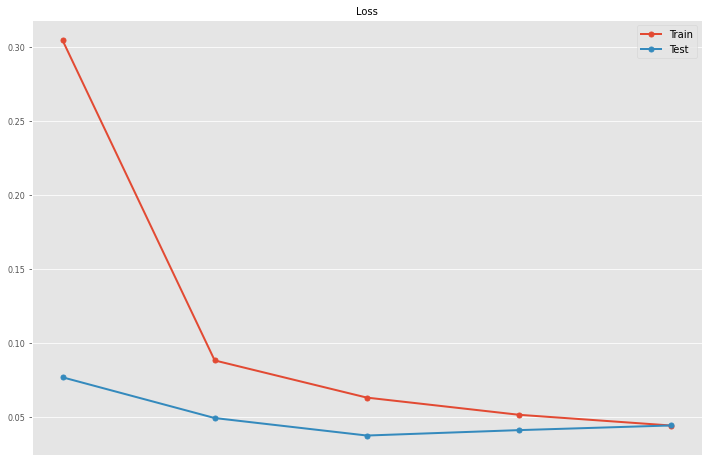

In [79]:
plotMeasure(history3_df.loss, history3_df.val_loss, 'Loss')

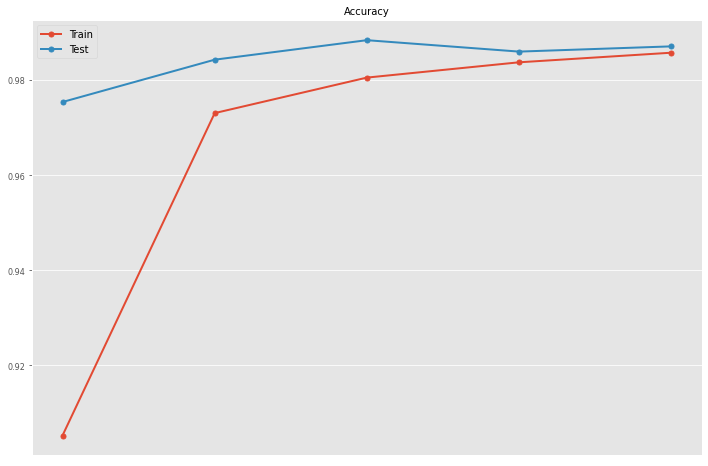

In [78]:
plotMeasure(history3_df.accuracy, history3_df.val_accuracy, 'Accuracy')

In [38]:
predictions_train_3 = np.argmax(model3.predict(train_images_tensor), axis=-1)

/Users/giorgio/opt/anaconda3/envs/d2l/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


In [39]:
print(confusion_matrix(train_labels, predictions_train_3))

[[5920    0    1    0    0    0    0    0    1    1]
 [   1 6715   15    1    1    0    0    6    0    3]
 [   5    3 5939    0    3    0    0    3    4    1]
 [   3    0   38 6063    1    1    0    3   13    9]
 [   6    9    2    0 5778    0    1    1    3   42]
 [  17    2    2   51    1 5286   20    0   18   24]
 [  89   10    4    1    9    1 5795    0    9    0]
 [   0    9   44    1   12    0    0 6169    6   24]
 [  18   14   11    2    6    2    3    0 5779   16]
 [  17    3    0    3    6    0    0   10    6 5904]]


<Figure size 864x432 with 0 Axes>

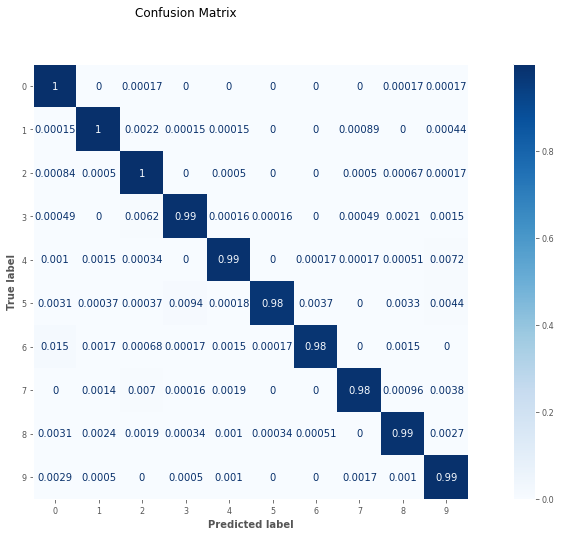

In [41]:
plt.figure(figsize=(12,6))
disp = ConfusionMatrixDisplay.from_predictions(train_labels, predictions_train_3, normalize='true', cmap='Blues')
disp.figure_.suptitle("Confusion Matrix")
plt.grid(None)
plt.show()

In [40]:
print('Training set accuracy: {0:5.3f}'.format(accuracy_score(train_labels, predictions_train_3)))

Training set accuracy: 0.989


In [42]:
meas = precision_recall_fscore_support(train_labels, predictions_train_3, average=None)
print('Test set')
for i in range(10):
  print('Class {0:d}: precision={1:5.3f}, recall={2:5.3f}, f-measure={2:5.3f}'.format(i, meas[1][i], meas[2][i], meas[3][i]))

Test set
Class 0: precision=0.999, recall=0.987, f-measure=0.987
Class 1: precision=0.996, recall=0.994, f-measure=0.994
Class 2: precision=0.997, recall=0.989, f-measure=0.989
Class 3: precision=0.989, recall=0.990, f-measure=0.990
Class 4: precision=0.989, recall=0.991, f-measure=0.991
Class 5: precision=0.975, recall=0.987, f-measure=0.987
Class 6: precision=0.979, recall=0.987, f-measure=0.987
Class 7: precision=0.985, recall=0.990, f-measure=0.990
Class 8: precision=0.988, recall=0.989, f-measure=0.989
Class 9: precision=0.992, recall=0.986, f-measure=0.986


In [44]:
predictions_test_3 = np.argmax(model3.predict(test_images_tensor), axis=-1)

/Users/giorgio/opt/anaconda3/envs/d2l/lib/python3.8/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


In [45]:
print(confusion_matrix(test_labels, predictions_test_3))

[[ 978    0    0    0    0    0    0    1    1    0]
 [   1 1132    1    0    0    0    0    1    0    0]
 [   1    1 1026    0    2    0    0    1    1    0]
 [   0    0    4 1004    0    1    0    0    1    0]
 [   1    0    0    0  970    0    0    0    0   11]
 [   3    0    1   15    0  867    2    1    1    2]
 [  16    2    0    0    2    1  936    0    1    0]
 [   0    2   11    0    0    0    0 1011    2    2]
 [   9    0    2    0    1    1    0    0  957    4]
 [   4    3    2    1    4    0    0    3    2  990]]


<Figure size 864x432 with 0 Axes>

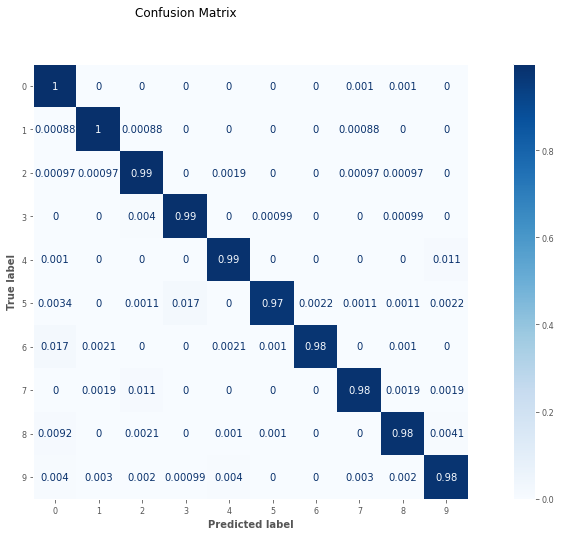

In [46]:
plt.figure(figsize=(12,6))
disp = ConfusionMatrixDisplay.from_predictions(test_labels, predictions_test_3, normalize='true', cmap='Blues')
disp.figure_.suptitle("Confusion Matrix")
plt.grid(None)
plt.show()

In [47]:
print('Test set accuracy: {0:5.3f}'.format(accuracy_score(test_labels, predictions_test_3)))

Test set accuracy: 0.987


In [48]:
meas = precision_recall_fscore_support(test_labels, predictions_test_3, average=None)
print('Test set')
for i in range(10):
  print('Class {0:d}: precision={1:5.3f}, recall={2:5.3f}, f-measure={2:5.3f}'.format(i, meas[1][i], meas[2][i], meas[3][i]))

Test set
Class 0: precision=0.998, recall=0.981, f-measure=0.981
Class 1: precision=0.997, recall=0.995, f-measure=0.995
Class 2: precision=0.994, recall=0.987, f-measure=0.987
Class 3: precision=0.994, recall=0.989, f-measure=0.989
Class 4: precision=0.988, recall=0.989, f-measure=0.989
Class 5: precision=0.972, recall=0.984, f-measure=0.984
Class 6: precision=0.977, recall=0.987, f-measure=0.987
Class 7: precision=0.983, recall=0.988, f-measure=0.988
Class 8: precision=0.983, recall=0.987, f-measure=0.987
Class 9: precision=0.981, recall=0.981, f-measure=0.981
